<a href="https://colab.research.google.com/github/pablillo77/nlp_and_deep_learning/blob/main/DS_NLP_DeepLearning_Final_Pablo_Gim%C3%A9nez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b> 🎬 Introduction 🎬</b></div>

## Presentation ##
The present project is based on a Kaggle dataset about BBC articles. The objective is to train and produce an algorithm for accurate news classification into five categories, that could yield commericial applications, customizing user engagement and giving insights for targeted audiences.

## Audience ##

This includes both readers seeking relevant content and businesses interested in market research, who could use categorized news for industry insights.

## Comercial Context ##

Personalized content delivery could improve user satisfaction and time spent on the platform. The classified data could also be valuable to marketing advertisers for audience targeting.

## Key Hypotheses and Questions ##

- Effective categorization and personalized news recommendations enhance reader engagement and retention.
- How the categories are distributed?
- Can we predict categories in new content?

## Objectives ##

- Produce an accurate classification model using LSTM and or RNN.
- Acquire category-based insights.
- Set the bases for future work on trending category predictions.





<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧹 Preliminary data cleaning 🧹</b></div>

 </b></div>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>⏳Libraries imports and data upload⏳
 </b></div>

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
import random


from collections import Counter
from wordcloud import WordCloud

# Sklearn mainly for model evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

# Tensorflow for creating and LSTM model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
#dataset load from github

#https://www.kaggle.com/code/dnkumars/lstm-model-bbc-articles-dataset/notebook?select=bbc_text_cls.csv
url = 'https://raw.githubusercontent.com/pablillo77/nlp_and_deep_learning/refs/heads/main/bbc_text_cls.csv'
df = pd.read_csv(url)
df.shape

(2225, 2)

In [3]:
#Some quick checks

pd.set_option('display.max_colwidth',None)
print("Data shape: ",df.shape)
print("Data types: ",df.dtypes)
df.sample(2)

Data shape:  (2225, 2)
Data types:  text      object
labels    object
dtype: object


text  \
1418                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Middlesbrough 2-2 Charlton\n\nA late header by teenager Danny Graham earned Middlesbrough a battling draw with Charlton at the Riverside.\n\nMatt Holland had put the visitors ahead in the 14th minute after his shot took a deflection off Franck Queudrue. But Middlesbrough peppered the Charlton goal after the break and Chris Riggott stroked home the equaliser. Shaun Bartlett's strike put Charlton back in front but that lead lasted just six minutes before Graham rushed onto Queudrue's pass to head home. The match burst to life from the whistle and Charlton defender Hermann Hreidarsson had sight of an open goal after just six minutes. Hreidarsson received Danny Murphy's free-kick from the right but he crashed his free header wide of the far post. The Iceland international looked such a danger the Boro bench could be heard issuing frantic instructions to mark him.\n\nCharlton's early pressure paid off when Bartlett received a long ball from Talal El Karkouri in the box and laid it off to Holland who buried his right-footed strike. Szilard Nemeth, recalled in place of Joseph-Desire Job, was twice denied his chance to get Middlesbrough back on level terms by Dean Kiely. The striker played a great one-two with Jimmy Floyd Hasselbaink only to see Kiely get down well to smother his shot before directing a header straight into the keeper's arms. Boro had plenty of time on the ball but the Addicks comfortably mopped up the pressure - with Kiely tipping a Hasselbaink header over the bar - to take their lead into half-time.\n\nIt was all one-way traffic after the break at the Riverside as Middlesbrough poured forward and Kiely even saved Hreidarsson's blushes when he palmed the ball away to prevent a Charlton own goal. But the Addicks keeper could do nothing about Riggott's equaliser in the 74th minute. The Boro defender looked suspiciously offside as he got on the end of Gareth Southgate's misdirected effort, but despite the Charlton protests his goal stood. The Addicks did not let their heads drop and Bartlett left the Boro defence standing, picking up Hreidarsson's cross to easily sink his right-footed strike. But substitute Graham was on hand to grab a share of the points for the home side. The 19-year-old striker nodding home the equaliser - and his first Premiership goal - with five minutes left on the clock.\n\n"I felt we did enough to win the game even though the first half was lacklustre. "We dominated after the break, the players showed a fantastic response and we should have gone on to win. "But for (Charlton goalkeeper) Dean Kiely, who made three tremendous saves, we could have scored five or six."\n\n"To take the lead and then to get penned back, it feels a little bit like a defeat," admitted Kiely. "We were winning but Middlesbrough kept knocking on the door. But we stood up and credit to us we didn't capitulate. "We'll kick on now. Our short-term ambition is to progress from the seventh place finish from last year."\n\nNash, Reiziger (Graham 82), Riggott, Southgate, Queudrue, Parlour (Job 86), Doriva, Nemeth (Parnaby 87), Zenden, Downing, Hasselbaink.\n\nSubs Not Used: Cooper, Knight.\n\nRiggott 74, Graham 86.\n\nKiely, Hreidarsson, Perry, El Karkouri, 

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* We can appreciate the dataset has 2 columns, text and labels, consiting of 2225 entries. The data types are objects, "text" will be converted to string for further processing, and the labels will be encoded.
* In the random sample we see numbers, speciall chars such as new line characters that do not add value to the categorization, stop words and capital letters.

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧹 Data preliminary cleanup 🧹</b></div>

In [4]:
df['text'] = df['text'].astype(str)	 # Convert to string before regex
df['text'] = df['text'].str.lower() # Conversion to lowercase

df['text'] = (
    df['text']
    .str.replace(r'\d+', '', regex=True)           # Remove digits
    .str.replace(r'[^\w\s]', '', regex=True)        # Remove special characters except for word chars and whitespace
    .str.replace(r'\n', ' ', regex=True)            # Replace newlines with space
    .str.replace(r'\\', '', regex=True)             # Remove any remaining backslashes
    .str.replace(r'"', '', regex=True)              # Remove double quotes
    .str.strip()                                    # Trim leading/trailing whitespace
)




<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🔎 Exploratory Data Analysis (EDA).🔎</b></div>

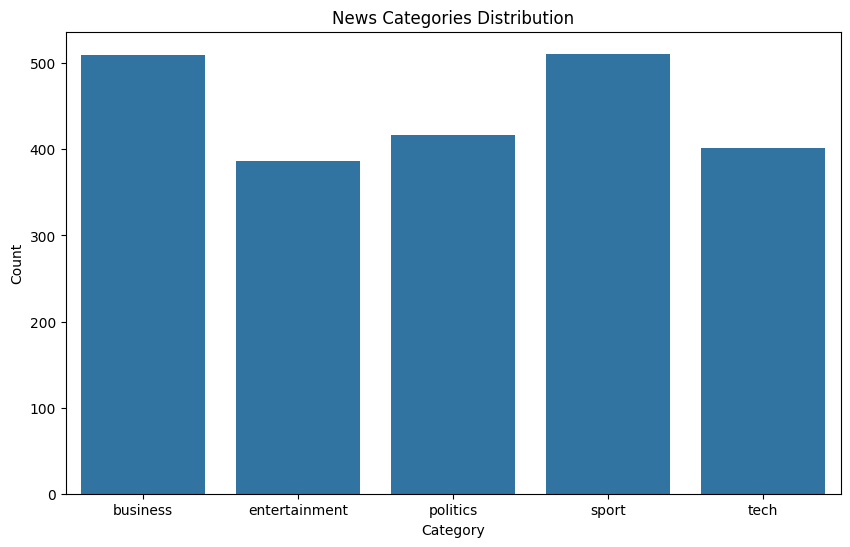

In [5]:
# Check categories distribution

plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=df)
plt.title(f'News Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


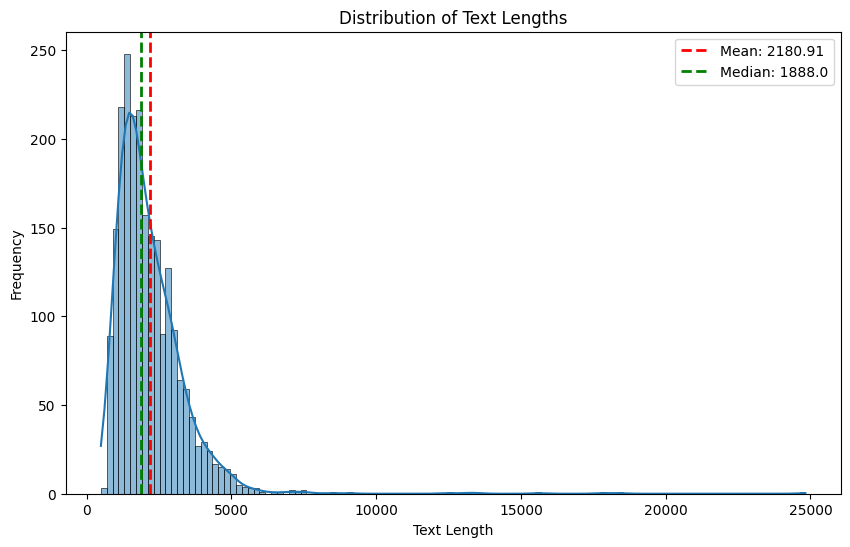

In [6]:
# Checking Text lenghts

df['text_length'] = df['text'].apply(len) # create a new column

mean_length = df['text_length'].mean()
median_length = df['text_length'].median()

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_length}')

plt.legend()
plt.show()

In [7]:
# Find the longest text element and its length

longest_text = df['text'].iloc[df['text'].str.len().idxmax()]
longest_text_length = len(longest_text)

print(f"Longest text element:\n{longest_text}\n")
print(f"Character count: {longest_text_length}")

Longest text element:
terror powers expose tyranny  the lord chancellor has defended government plans to introduce control orders to keep foreign and british terrorist suspects under house arrest where there isnt enough evidence to put them on trial  lord falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties but thriller writer frederick forsyth tells bbc news of his personal response to the move    there is a mortal danger aimed at the heart of britain or so says home secretary charles clarke my reaction so what it is not that i am cynical or just do not care i care about this country very much  but in the  years that i have been alive there has not been one hour of one day of one month of one year when there has not been a threat aimed at us my point is the british have always coped without becoming a dictatorship we have coped with fear without becoming a st

In [8]:
# Stopwords removal

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)


df['text']=df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


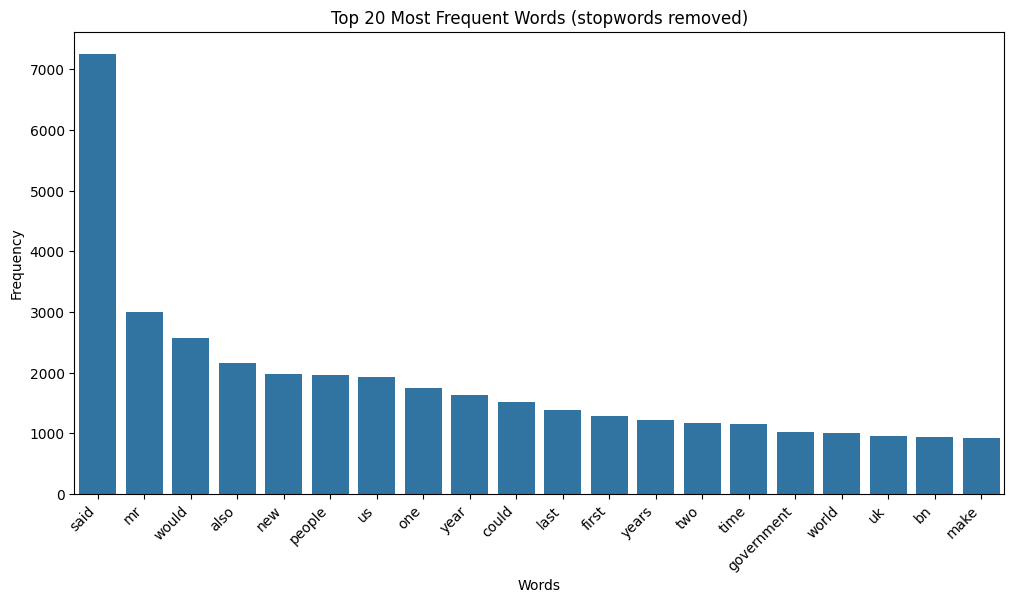

In [9]:
# Counting most frequent words

from collections import Counter

# Assuming 'df' and 'text' column exist as in the provided code
word_counts = Counter(" ".join(df['text']).split())
top_20_words = word_counts.most_common(20)

# Extract words and counts for plotting
words, counts = zip(*top_20_words)

# Create the countplot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words (stopwords removed)')
plt.show()

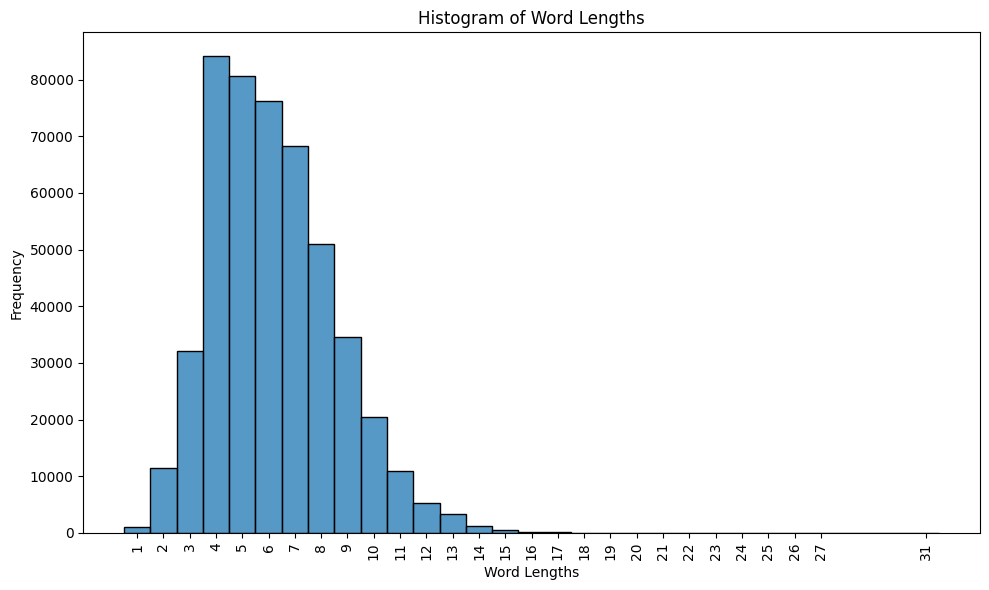

In [10]:
def word_length_histogram(df):
    word_lengths = []
    for text in df['text']:
        words = text.split()
        for word in words:
          word_lengths.append(len(word))

    unique_word_lengths = sorted(list(set(word_lengths)))

    plt.figure(figsize=(10, 6))
    sns.histplot(word_lengths, discrete=True)
    plt.xticks(unique_word_lengths, rotation=90)
    plt.xlabel('Word Lengths')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Lengths')
    plt.tight_layout()
    plt.show()

word_length_histogram(df)

In [17]:
# Unique word count analysis, for later use in creating a model

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Fit the text column into a BoW matrix
matrix_bow = vectorizer.fit_transform(df["text"])

# Generated vocabulary
vocabulary  = vectorizer.get_feature_names_out()

unique_word_count = len(np.unique(vocabulary ))

print(f"Number of unique words: {unique_word_count}")

Number of unique words: 31386


In [18]:
# N-grams analysis

from nltk import ngrams


def analyze_ngrams(df, column_name, n=2):
    all_ngrams = []
    for text in df[column_name]:
        # Tokenize the text
        tokens = nltk.word_tokenize(str(text).lower())  # Convert to lowercase

        # Generate n-grams
        text_ngrams = list(ngrams(tokens, n))

        # Extend the list of all n-grams
        all_ngrams.extend(text_ngrams)

    # Count the frequency of each n-gram
    ngram_counts = Counter(all_ngrams)

    # Print or return the most frequent n-grams
    print(f"Top 10 most frequent {n}-grams:\n")
    for ngram, count in ngram_counts.most_common(10):
        print(f"{ngram}: {count}")


analyze_ngrams(df, 'text', n=2)  # Analyze bigrams
print("\n")
analyze_ngrams(df, 'text', n=3)  # Analyze trigrams
print("\n")
analyze_ngrams(df, 'text', n=4)  # Analyze 4grams

Top 10 most frequent 2-grams:

('last', 'year'): 384
('said', 'mr'): 359
('told', 'bbc'): 348
('mr', 'blair'): 296
('prime', 'minister'): 274
('mr', 'brown'): 214
('chief', 'executive'): 198
('said', 'would'): 192
('bbc', 'news'): 178
('general', 'election'): 172


Top 10 most frequent 3-grams:

('told', 'bbc', 'news'): 147
('bbc', 'news', 'website'): 94
('told', 'bbc', 'radio'): 76
('leader', 'michael', 'howard'): 55
('mr', 'blair', 'said'): 54
('million', 'dollar', 'baby'): 50
('radio', 'today', 'programme'): 49
('told', 'bbc', 'sport'): 48
('bbc', 'radio', 'today'): 47
('tory', 'leader', 'michael'): 41


Top 10 most frequent 4-grams:

('told', 'bbc', 'news', 'website'): 77
('bbc', 'radio', 'today', 'programme'): 44
('told', 'bbc', 'radio', 'today'): 39
('tory', 'leader', 'michael', 'howard'): 38
('prime', 'minister', 'tony', 'blair'): 26
('foreign', 'secretary', 'jack', 'straw'): 22
('home', 'secretary', 'charles', 'clarke'): 21
('bbc', 'radio', 'five', 'live'): 18
('shadow', 'chanc

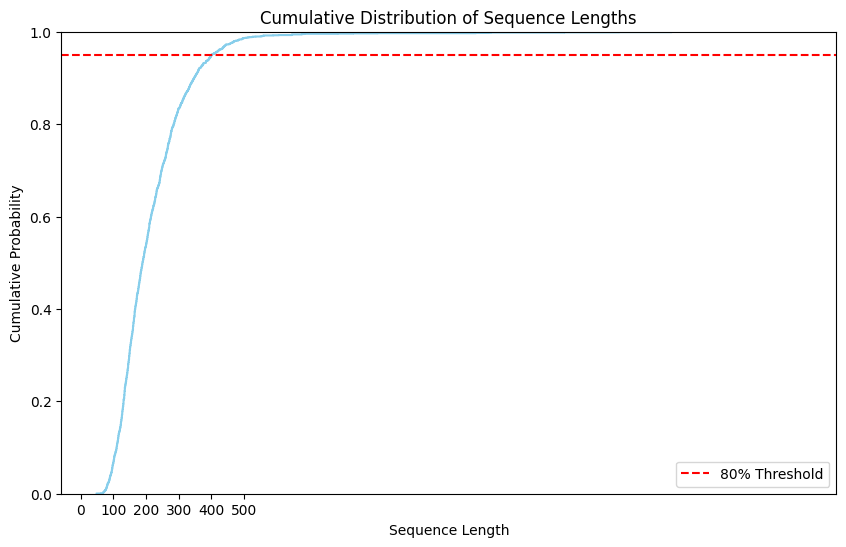

In [19]:
#Study the distribution of sequence lengths

# Prepare text data
texts = df['text'].values

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Create a DataFrame for easier analysis
lengths_df = pd.DataFrame(sequence_lengths, columns=['length'])

# Plot the cumulative distribution of sequence lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=lengths_df, x='length', color='skyblue')
plt.xlabel('Sequence Length')
plt.xticks(range(0, 600, 100))
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Sequence Lengths')
plt.axhline(y=0.95, color='red', linestyle='--', label='80% Threshold')
plt.legend()
plt.show()



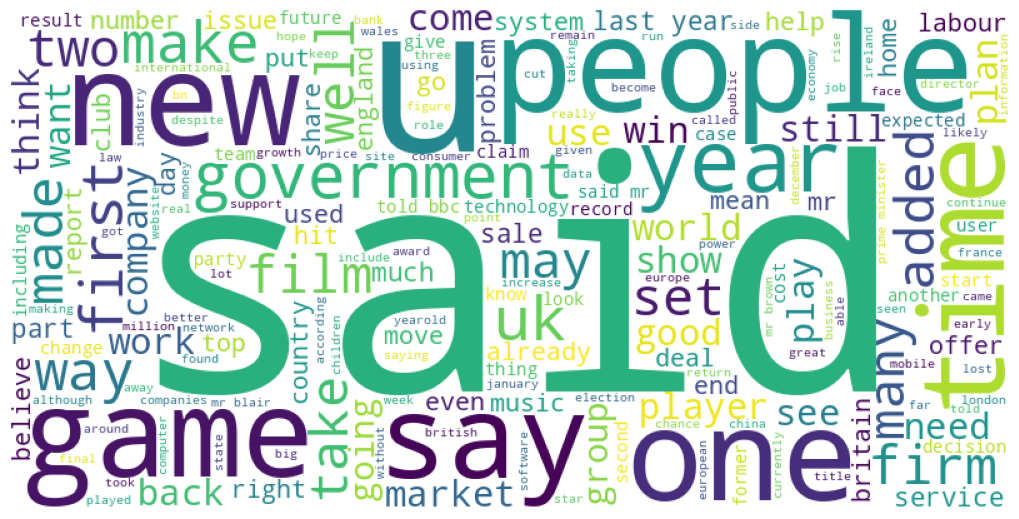

In [20]:
# Create the word cloud

text = " ".join(text for text in df['text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* The categories (labels) have a good classes balance in the dataset.
* Text lenght analysis, shows a distribution with a mean value of 218 characters, the longest text has 24829.
* Most frequent words are "said" and "mr", "would", consisten with the reporting tone and style of a news channel.
* The word lenghts analysis, indicates that having removed the stopwords (usually words of 2 or 3 letters if language is English) the next most frequent lengths are 4 and 5 letters long. Again there is agreement with the language used.
* We found 31386 different and unique words.
* N-Grams study shows context also in agreemnent with the reporting style of a news channel. "last year", "told BBC news" and "told BBC nwes website" are the most frequent for bigrams, trigrams and four-grams.

# Model

In [54]:
# Define a plotting Losses curves

def plot_training_history(model):
  """Plots the training and validation loss from a Keras model's history.

  Args:
    model: A trained Keras model with a history attribute.
  """
  plt.figure(figsize=(10, 6))
  plt.plot(model.history.history['loss'], label='Training Loss')
  plt.plot(model.history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

In [67]:
# Prepare text data and labels
X = df['text'].values
y = df['labels'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

# Tokenization and padding
max_words = 20000  # Number of unique words to use
max_length = 300  # Maximum length of input sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)


# Building the LSTM model

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
# Training the model
model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2900 - loss: 1.5349 - val_accuracy: 0.5758 - val_loss: 1.1211
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6362 - loss: 0.9373 - val_accuracy: 0.6264 - val_loss: 0.8944
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9035 - loss: 0.4239 - val_accuracy: 0.8427 - val_loss: 0.4375
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9772 - loss: 0.1278 - val_accuracy: 0.9129 - val_loss: 0.2754
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9952 - loss: 0.0440 - val_accuracy: 0.9045 - val_loss: 0.3159
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9972 - loss: 0.0351 - val_accuracy: 0.9213 - val_loss: 0.2318
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9410 - val_loss: 0.2093
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9410 - v

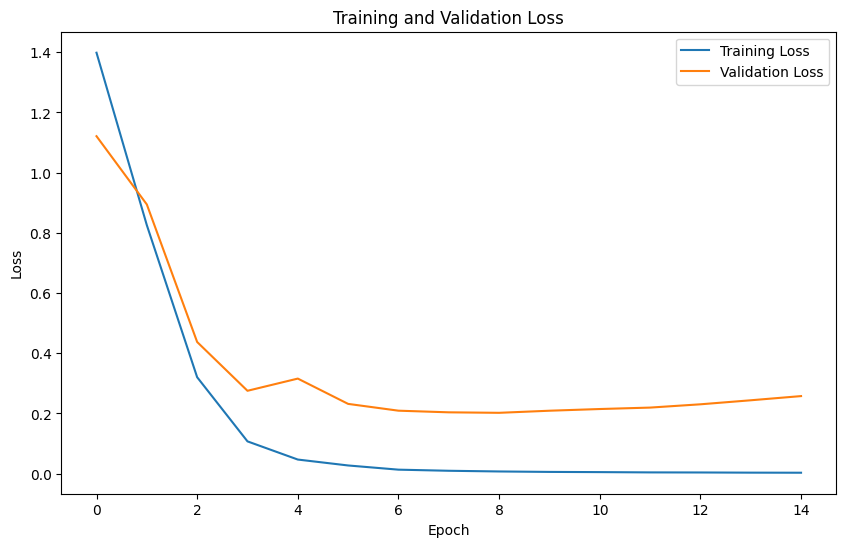

In [64]:
# Plotting the loss function for training and validation sets
# Plotting the loss function for training and validation sets
plt.figure(figsize=(10, 6))
# Access the history using history.history
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [70]:
# Building the LSTM model2

model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(32))
model2.add(Dropout(0.2))
model2.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compiling the model2
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [71]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Crear el callback para reducir el learning rate cuando la validación no mejora
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entrenar el modelo con el callback
model2.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3110 - loss: 1.5095 - val_accuracy: 0.6798 - val_loss: 0.9200 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7101 - loss: 0.7294 - val_accuracy: 0.8174 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8359 - loss: 0.4818 - val_accuracy: 0.7360 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8565 - loss: 0.3324 - val_accuracy: 0.8315 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9769 - loss: 0.1707 - val_accuracy: 0.8848 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9965 - loss: 0.0478 - val_accuracy: 0.8764 - val_loss: 0.4280 - learning_rate: 0.0010
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9986 - loss: 0.0286 - val_acc

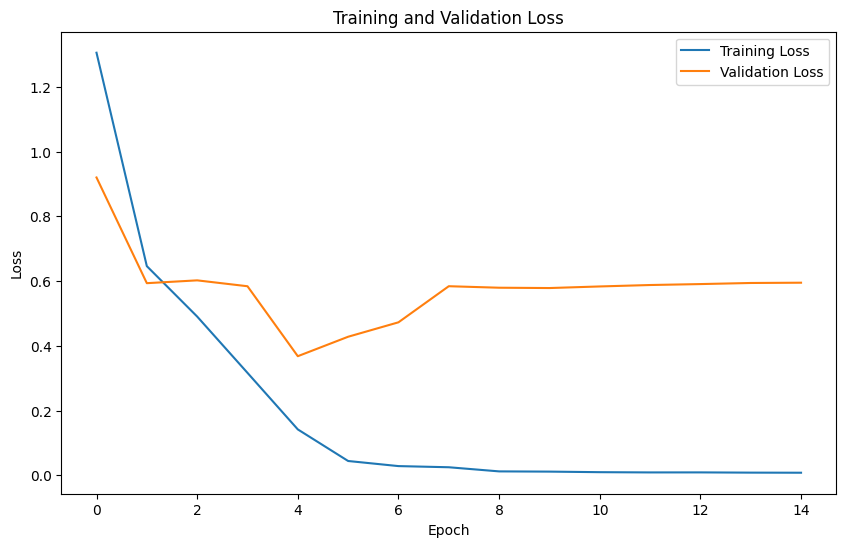

In [72]:
plot_training_history(model2)

In [24]:
# Predicting on test data
y_test_predictions = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_predictions, axis=1)

# Calculate metrics for test data
accuracy = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, average='macro')
recall = recall_score(y_test, y_test_pred_classes, average='macro')
f1 = f1_score(y_test, y_test_pred_classes, average='macro')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [25]:
# Display results
results = pd.DataFrame({
    'model': ['LSTM'],
    'precision': [precision],
    'recall': [recall],
    'F1': [f1],
    'accuracy': [accuracy]
})
print("Test Results:")
print(results)

Test Results:
  model  precision    recall        F1  accuracy
0  LSTM   0.882497  0.881208  0.879328  0.878652


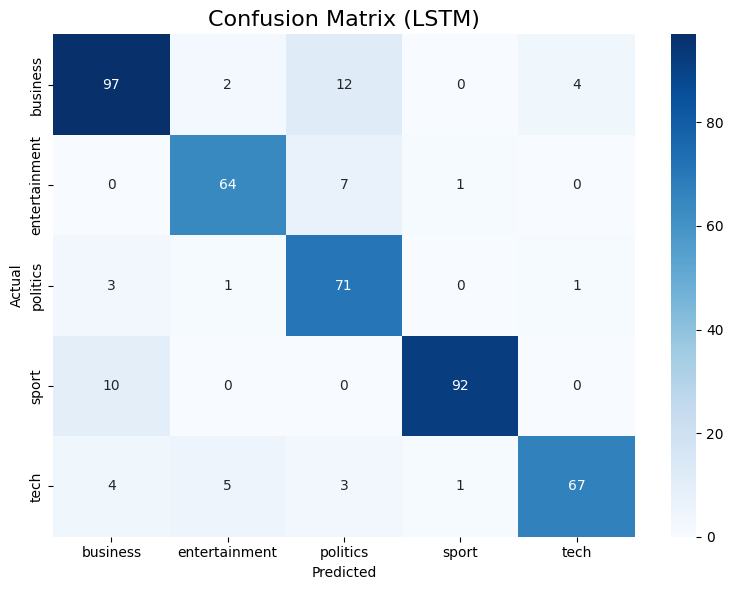

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix (LSTM)', fontsize=16)
ax.xaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.yaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# prompt: test the model randomly selecting 3 values, sow the prediction and the actual value

# Select 3 random indices from the test data
random_indices = random.sample(range(len(X_test)), 5)

# Loop through the selected indices
for index in random_indices:
    # Get the text and true label
    text = X_test.iloc[index]
    true_label = y_test[index]

    # Preprocess the text for prediction
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)

    # Predict the category
    prediction = model.predict(text_padded)
    predicted_label = np.argmax(prediction)

    # Decode the predicted label
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]
    true_category = label_encoder.inverse_transform([true_label])[0]

    # Print the results
    print(f"Text: {text[:100]}...")  # Print the first 100 characters of the text
    print(f"Predicted Category: {predicted_category}")
    print(f"Actual Category: {true_category}")
    print("-" * 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Text: kluft impressed sotherton form olympic heptathlon champion carolina kluft full admiration britains k...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: osullivan commits dublin race sonia osullivan seek regain title bupa great ireland run april dublin ...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Text: new york rockers top talent poll new york electrorock group bravery come top bbc news websites sound...
Predicted Category: entertainment
Actual Category: entertainment
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Text: asylum children face returns uk government planning return asylum seeker children without parents al...
Predicted Category: politics
Actual Category: politics
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: almagro continues spanish surge unseeded nicolas almagro becam

In [ ]:
# prompt: create an input box for entering text as a testing input for this model, show the predicted category.

#@title Enter text for category prediction
text_input = "Health Secretary Wes Streeting has ordered a review of the costs for the NHS of implementing any changes in the law on assisted dying.  Streeting, who plans to vote against a new assisted dying bill when it is debated later this month, has suggested introducing what is proposed could lead to cuts in other NHS services" #@param {type:"string"}

# Preprocess the text input
text_sequence = tokenizer.texts_to_sequences([text_input])
text_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the category
prediction = model.predict(text_padded)
predicted_label = np.argmax(prediction)

# Decode the predicted label
predicted_category = label_encoder.inverse_transform([predicted_label])[0]

# Print the predicted category
print(f"Predicted Category: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Category: sport


In [ ]:
# prompt: test 5 randomly selected texts from sport category only and test the predictions

# Select 5 random indices from the test data belonging to the 'sport' category
sport_indices = df[df['labels'] == 'sport'].index.tolist()
random_sport_indices = random.sample(sport_indices, 5)

# Loop through the selected indices
for index in random_sport_indices:
    # Get the text and true label
    text = df['text'].iloc[index]
    true_label = df['labels'].iloc[index]

    # Preprocess the text for prediction
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)

    # Predict the category
    prediction = model.predict(text_padded)
    predicted_label = np.argmax(prediction)

    # Decode the predicted label
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]

    # Print the results
    print(f"Text: {text[:100]}...")  # Print the first 100 characters of the text
    print(f"Predicted Category: {predicted_category}")
    print(f"Actual Category: {true_label}")
    print("-" * 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Text: saintandre anger absent stars sale sharks director rugby philippe saintandre reopened rugbys clubver...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Text: fear help france laporte france coach bernard laporte believes team scared going game england sunday...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Text: candela completes bolton switch bolton boss sam allardyce signed roma defender vincent candela fivem...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Text: aragones angered racism fine spain coach luis aragones furious fined spanish football federation com...
Predicted Category: politics
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Text: thanou desperate make return greek sprinter katerina thanou says eager compete